## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint
from sklearn.metrics import f1_score

import gc
import optuna
from sklearn.feature_selection import RFE
from math import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import tanh
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

from tensorflow.keras.layers import Flatten,Activation,Dense,Dropout, Conv2D, \
Concatenate, LeakyReLU, MaxPooling2D, Reshape, Input, LSTM

/tmp/ipykernel_5890/879617972.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-12 13:54:55.519768: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 13:54:55.558681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2

In [2]:
df = pd.read_csv('/home/ec2-user/Capstone/pair_features_updated_300_20.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading
0,2015-01-02,MMM,119.196,AKAM,63.250,165.080,63.900,162.730,62.520,2116400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709,False
1,2015-01-05,MMM,116.507,AKAM,61.940,163.640,62.340,160.080,60.760,3692900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.547,False
2,2015-01-06,MMM,115.265,AKAM,60.670,161.370,62.190,157.740,60.100,3532000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.122,False
3,2015-01-07,MMM,116.101,AKAM,60.160,160.280,60.960,158.940,59.930,3081300.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883,False
4,2015-01-08,MMM,118.883,AKAM,61.570,163.690,61.860,160.520,60.600,3142900.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.170,False


In [3]:
df['pnls'] = df['pnls']*100.0

In [4]:
total_days = df.Date.nunique()
total_days

1257

In [5]:
print(df.shape)
df.isna().sum()

(1539825, 33)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
same_sector_flag                  0
same_sub_industry_flag            0
abs_spread_mean              366275
abs_spread_std               366275
abs_spread_mean_l20           23275
abs_spread_std_l20            23275
spread_normed                366275
abs_spread_normed_max        732550
abs_spread_normed_90th       732550
abs_spread_normed_75th       732550
abs_spread_normed_median     732550
abs_spread_normed_l7_avg     373625
abs_spread_normed_l14_avg    382200
cos_sim                      366275
corr_coef                    366275
pnls                        

In [6]:
df.Date.nunique()

1257

In [7]:
df.abs_spread_normed_max.dropna().describe()

count   807275.000
mean         3.091
std          0.662
min          1.002
25%          2.642
50%          3.015
75%          3.457
max          7.195
Name: abs_spread_normed_max, dtype: float64

In [8]:
tmp_df = df[(df.Ticker_P1 == 'TDY') & (df.Ticker_P2 == 'PEP')]
tmp_df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading


In [9]:
tmp_df.abs_spread_normed_max

Series([], Name: abs_spread_normed_max, dtype: float64)

In [10]:
df = df.sort_values('Date')

In [11]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


In [12]:
for i in range(17,20):
    df['FUTURE_abs_spread_'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

df['FUTURE_abs_spread_avg'] = df[[c for c in df.columns if 'FUTURE_abs_spread_' in c]].mean(axis=1)

# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

# df['PCT_CHANGE'] = (df['FUTURE_abs_spread_avg'] - df['abs_spread'])*100.0/df['abs_spread']
# df['direction'] = np.where(df['PCT_CHANGE'].abs()<3,0,np.where(df['PCT_CHANGE']>0,1,-1))

df['direction'].value_counts()
# df['direction'] = df['PCT_CHANGE']

direction
0    1103636
1     436189
Name: count, dtype: int64

In [13]:
# df[['FUTURE_abs_spread_avg']+['FUTURE_abs_spread_'+str(i) for i in range(1,4)]]

In [14]:
# stop

In [15]:
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading,FUTURE_abs_spread_17,FUTURE_abs_spread_18,FUTURE_abs_spread_19,FUTURE_abs_spread_avg,direction
0,2015-01-02,MMM,119.196,AKAM,63.250,165.080,63.900,162.730,62.520,2116400.000,...,NaN,NaN,NaN,-1.709,False,60.119,60.750,59.757,60.208,0
1026969,2015-01-02,ETN,53.591,WHR,142.168,68.570,196.140,66.990,191.260,1638100.000,...,NaN,NaN,NaN,-1.709,False,98.172,99.586,96.866,98.208,0
1474461,2015-01-02,ODFL,50.298,QRVO,70.400,52.407,71.999,50.840,68.010,529350.000,...,NaN,NaN,NaN,-1.709,False,28.369,29.498,28.368,28.745,0
65364,2015-01-02,AKAM,63.250,BDX,119.901,63.900,137.444,62.520,135.980,846000.000,...,NaN,NaN,NaN,-1.709,False,61.734,60.337,60.215,60.762,0
1283397,2015-01-02,ISRG,58.397,MAA,55.570,59.533,76.190,57.923,74.470,1603800.000,...,NaN,NaN,NaN,-1.709,False,4.368,3.363,3.498,3.743,0


# Bad Data

In [16]:
print(df.shape)
df = df[df['Volume_P1']>0]
print(df.shape)
df = df[df['Volume_P2']>0]
print(df.shape)


(1539825, 38)
(1539811, 38)
(1539727, 38)


In [17]:
df = df[df['abs_spread']>=1]
print(df.shape)

(1516771, 38)


# Feature Engineering

In [18]:
df = df[['Date', 'Ticker_P1', 'Ticker_P2', 'Close_P1', 'Volume_P1', 'Close_P2', 'Volume_P2','direction','pnls', 'num_entries']]

In [19]:
df = df.sort_values('Date')

In [20]:
history_window = 150

In [21]:
for i in tqdm(range(1,history_window+1)):
    for c in ['Close_P1','Volume_P1', 'Close_P2','Volume_P2']:
        df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)

  0%|          | 0/150 [00:00<?, ?it/s]

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PREV_'+str(i)+'_'+c] = df.groupby(['Ticker_P1','Ticker_P2'])[c].shift(i)
/tmp/ipykernel_5890/73856407.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [22]:
df.isna().sum().sort_values(ascending=False)

pnls                  384573
num_entries           384573
PREV_150_Volume_P2    183750
PREV_150_Close_P2     183750
PREV_150_Volume_P1    183750
                       ...  
Ticker_P1                  0
Close_P2                   0
Volume_P2                  0
direction                  0
Date                       0
Length: 610, dtype: int64

In [23]:
print(df.shape,df.Date.nunique())
df = df.dropna()
print(df.shape,df.Date.nunique())


(1516771, 610) 1257
(1132073, 610) 937


In [24]:
features = [c for c in df.columns for j in ['Close_P1','Volume_P1','Close_P2', 'Volume_P2'] if j in c]
features

['Close_P1',
 'Volume_P1',
 'Close_P2',
 'Volume_P2',
 'PREV_1_Close_P1',
 'PREV_1_Volume_P1',
 'PREV_1_Close_P2',
 'PREV_1_Volume_P2',
 'PREV_2_Close_P1',
 'PREV_2_Volume_P1',
 'PREV_2_Close_P2',
 'PREV_2_Volume_P2',
 'PREV_3_Close_P1',
 'PREV_3_Volume_P1',
 'PREV_3_Close_P2',
 'PREV_3_Volume_P2',
 'PREV_4_Close_P1',
 'PREV_4_Volume_P1',
 'PREV_4_Close_P2',
 'PREV_4_Volume_P2',
 'PREV_5_Close_P1',
 'PREV_5_Volume_P1',
 'PREV_5_Close_P2',
 'PREV_5_Volume_P2',
 'PREV_6_Close_P1',
 'PREV_6_Volume_P1',
 'PREV_6_Close_P2',
 'PREV_6_Volume_P2',
 'PREV_7_Close_P1',
 'PREV_7_Volume_P1',
 'PREV_7_Close_P2',
 'PREV_7_Volume_P2',
 'PREV_8_Close_P1',
 'PREV_8_Volume_P1',
 'PREV_8_Close_P2',
 'PREV_8_Volume_P2',
 'PREV_9_Close_P1',
 'PREV_9_Volume_P1',
 'PREV_9_Close_P2',
 'PREV_9_Volume_P2',
 'PREV_10_Close_P1',
 'PREV_10_Volume_P1',
 'PREV_10_Close_P2',
 'PREV_10_Volume_P2',
 'PREV_11_Close_P1',
 'PREV_11_Volume_P1',
 'PREV_11_Close_P2',
 'PREV_11_Volume_P2',
 'PREV_12_Close_P1',
 'PREV_12_Volum

In [103]:
features_for_presentation = []
for i in tqdm(range(1,history_window+1)):
    for c in ['Close_P1','Volume_P1', 'Close_P2','Volume_P2']:
        features_for_presentation.append('t-'+str(i)+'_'+c)
for i in range(len(features)):
    if (i+1)%4==0:
        print(features_for_presentation[i])
    else:
        print(features_for_presentation[i],end=' ')
               

  0%|          | 0/150 [00:00<?, ?it/s]

t-1_Close_P1 t-1_Volume_P1 t-1_Close_P2 t-1_Volume_P2
t-2_Close_P1 t-2_Volume_P1 t-2_Close_P2 t-2_Volume_P2
t-3_Close_P1 t-3_Volume_P1 t-3_Close_P2 t-3_Volume_P2
t-4_Close_P1 t-4_Volume_P1 t-4_Close_P2 t-4_Volume_P2
t-5_Close_P1 t-5_Volume_P1 t-5_Close_P2 t-5_Volume_P2
t-6_Close_P1 t-6_Volume_P1 t-6_Close_P2 t-6_Volume_P2
t-7_Close_P1 t-7_Volume_P1 t-7_Close_P2 t-7_Volume_P2
t-8_Close_P1 t-8_Volume_P1 t-8_Close_P2 t-8_Volume_P2
t-9_Close_P1 t-9_Volume_P1 t-9_Close_P2 t-9_Volume_P2
t-10_Close_P1 t-10_Volume_P1 t-10_Close_P2 t-10_Volume_P2
t-11_Close_P1 t-11_Volume_P1 t-11_Close_P2 t-11_Volume_P2
t-12_Close_P1 t-12_Volume_P1 t-12_Close_P2 t-12_Volume_P2
t-13_Close_P1 t-13_Volume_P1 t-13_Close_P2 t-13_Volume_P2
t-14_Close_P1 t-14_Volume_P1 t-14_Close_P2 t-14_Volume_P2
t-15_Close_P1 t-15_Volume_P1 t-15_Close_P2 t-15_Volume_P2
t-16_Close_P1 t-16_Volume_P1 t-16_Close_P2 t-16_Volume_P2
t-17_Close_P1 t-17_Volume_P1 t-17_Close_P2 t-17_Volume_P2
t-18_Close_P1 t-18_Volume_P1 t-18_Close_P2 t-18_Vo

IndexError: list index out of range

# Regression

## Remove 0s?

In [25]:
df[df.pnls==0].shape[0]*100.0/df.shape[0]

41.68123433736164

In [26]:
# df = df[df.pnls!=0]


## X,y split

In [27]:
# df['DIFF_pnls'] = df['pnls'] - df['PREV_1_pnls']

In [28]:
label = 'direction'


In [29]:
X = df[features].values
y = df[label]

In [30]:
print(X.shape)

(1132073, 604)


In [31]:
# y = pd.Series(np.where(y.abs()<1,0,np.where(y<0,-1,1)))
# y = pd.Series(np.where(y>=4,1,0))

## Train test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [33]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)
X_val, y_val = undersample.fit_resample(X_val, y_val)

In [34]:
y_val.value_counts()

direction
0    45575
1    45575
Name: count, dtype: int64

In [35]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)


## Scaling

In [36]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [37]:
scaled_X_train = scaled_X_train.reshape(scaled_X_train.shape[0],int(scaled_X_train.shape[1]/4),4)
scaled_X_val = scaled_X_val.reshape(scaled_X_val.shape[0],int(scaled_X_val.shape[1]/4),4)
scaled_X_test = scaled_X_test.reshape(scaled_X_test.shape[0],int(scaled_X_test.shape[1]/4),4)

print(scaled_X_train.shape)
print(scaled_X_val.shape)
print(scaled_X_test.shape)

(679346, 151, 4)
(91150, 151, 4)
(113208, 151, 4)


# CNN

In [38]:
def get_model():
    leaky_relu_alpha = 0.3
    h_units = 32
    kernel_reg = L2(0.01)
    
    input1 = Input(shape=(scaled_X_train.shape[1],scaled_X_train.shape[2],1))
    
    y = Conv2D(h_units,(1,2),strides=(1,2),kernel_regularizer=kernel_reg)(input1)
    y = LeakyReLU(leaky_relu_alpha)(y)
#     y = Activation(tanh)(y)
    y = Conv2D(h_units,(1,2),strides=(1,2),kernel_regularizer=kernel_reg)(y)
    y = LeakyReLU(leaky_relu_alpha)(y)
#     y = Activation(tanh)(y)
    
    # build the inception module
    t1 = Conv2D(h_units, (1, 1), padding='same',kernel_regularizer=kernel_reg)(y)
    t1 = LeakyReLU(alpha=leaky_relu_alpha)(t1)
#     t1 = Activation(tanh)(t1)
    t1 = Conv2D(h_units, (5, 1), padding='same',kernel_regularizer=kernel_reg)(t1)
    t1 = LeakyReLU(alpha=leaky_relu_alpha)(t1)
#     t1 = Activation(tanh)(t1)

    t2 = Conv2D(h_units, (1, 1), padding='same',kernel_regularizer=kernel_reg)(y)
    t2 = LeakyReLU(alpha=leaky_relu_alpha)(t2)
#     t2 = Activation(tanh)(t2)
    t2 = Conv2D(h_units, (15, 1), padding='same',kernel_regularizer=kernel_reg)(t2)
    t2 = LeakyReLU(alpha=leaky_relu_alpha)(t2)
#     t2 = Activation(tanh)(t2)
  
    t3 = Conv2D(h_units, (1, 1), padding='same',kernel_regularizer=kernel_reg)(y)
    t3 = LeakyReLU(alpha=leaky_relu_alpha)(t3)
#     t3 = Activation(tanh)(t3)
    t3 = Conv2D(h_units, (30, 1), padding='same',kernel_regularizer=kernel_reg)(t3)
    t3 = LeakyReLU(alpha=leaky_relu_alpha)(t3)
#     t3 = Activation(tanh)(t3)

    t4 = Conv2D(h_units, (1, 1), padding='same',kernel_regularizer=kernel_reg)(y)
    t4 = LeakyReLU(alpha=leaky_relu_alpha)(t4)
#     t4 = Activation(tanh)(t4)
    t4 = Conv2D(h_units, (60, 1), padding='same',kernel_regularizer=kernel_reg)(t4)
    t4 = LeakyReLU(alpha=leaky_relu_alpha)(t4)
#     t4 = Activation(tanh)(t4)

    t5 = Conv2D(h_units, (1, 1), padding='same',kernel_regularizer=kernel_reg)(y)
    t5 = LeakyReLU(alpha=leaky_relu_alpha)(t5)
#     t5 = Activation(tanh)(t5)
    t5 = Conv2D(h_units, (120, 1), padding='same',kernel_regularizer=kernel_reg)(t5)
    t5 = LeakyReLU(alpha=leaky_relu_alpha)(t5)
#     t5 = Activation(tanh)(t5)


    t6 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(y)
    t6 = Conv2D(64, (1, 1), padding='same',kernel_regularizer=kernel_reg)(t6)
    t6 = LeakyReLU(alpha=0.01)(t6)

    all_time_periods = keras.layers.concatenate([t1, t2, t3, t4, t5,t6], axis=3)
    
    y = Reshape((int(all_time_periods.shape[1]), int(all_time_periods.shape[3])))(all_time_periods)
    y = Dropout(0.3)(y)

    # build the last LSTM layer
    conv_lstm = LSTM(h_units)(y)
    
    conv_lstm = Dropout(0.3)(conv_lstm)

    # build the output layer
    out = Dense(1,'sigmoid')(conv_lstm)
    
    model = Model(inputs=input1, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(optimizer=adam, loss='mean_squared_logarithmic_error', metrics=['mae'])
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model
    

In [39]:
def get_base_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=2, activation='relu', input_shape=(scaled_X_train.shape[1],scaled_X_train.shape[2],1)))
    model.add(Conv2D(32, kernel_size=2, activation='relu'))
    model.add(Flatten())    
    model.add(Dense(256,'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1,'sigmoid'))
    
    adam = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [40]:
# m1 = get_base_model()
m1 = get_model()

2024-03-12 13:56:54.204433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [41]:
m1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 151, 4, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 151, 2, 32)           96        ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 151, 2, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 151, 1, 32)           2080      ['leaky_re_lu[0][0]']         
                                                                                              

In [42]:
earlystopper = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=4,verbose=1,restore_best_weights=True)

In [43]:
history = m1.fit(scaled_X_train,y_train,\
                   epochs=10,\
                   batch_size=512,\
                   validation_data=(scaled_X_val,y_val),\
                   verbose=1,\
#                    callbacks=[earlystopper],\
                   shuffle=True
                  )

Epoch 1/10
1327/1327 [==============================] - 685s 515ms/step - loss: 2.1851 - accuracy: 0.6603 - val_loss: 1.3023 - val_accuracy: 0.7185
Epoch 2/10
1327/1327 [==============================] - 683s 514ms/step - loss: 1.0003 - accuracy: 0.7683 - val_loss: 0.8660 - val_accuracy: 0.7435
Epoch 3/10
1327/1327 [==============================] - 683s 515ms/step - loss: 0.7288 - accuracy: 0.7824 - val_loss: 0.7067 - val_accuracy: 0.7643
Epoch 4/10
1327/1327 [==============================] - 683s 515ms/step - loss: 0.6274 - accuracy: 0.7884 - val_loss: 0.6209 - val_accuracy: 0.7730
Epoch 5/10
1327/1327 [==============================] - 682s 514ms/step - loss: 0.5756 - accuracy: 0.7929 - val_loss: 0.5997 - val_accuracy: 0.7733
Epoch 6/10
1327/1327 [==============================] - 682s 514ms/step - loss: 0.5451 - accuracy: 0.7949 - val_loss: 0.5767 - val_accuracy: 0.7751
Epoch 7/10
1327/1327 [==============================] - 682s 514ms/step - loss: 0.5255 - accuracy: 0.7973 - val_

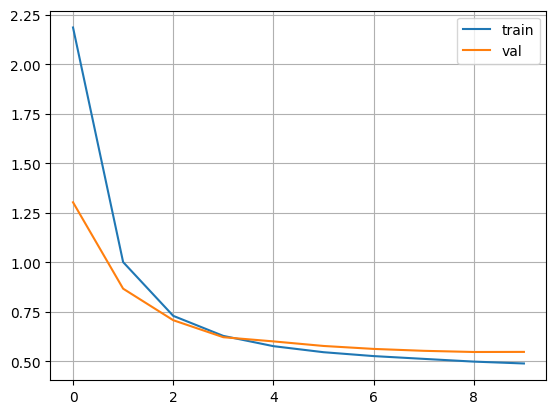

In [44]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.grid()
plt.show()

In [45]:
preds = m1.predict(scaled_X_test)

3538/3538 [==============================] - 56s 16ms/step


In [46]:
preds = np.where(preds.flatten()>0.5,1,0)

In [47]:
print('weighted f1: ', f1_score(y_test, preds, average='weighted'))
print('micro f1: ', f1_score(y_test, preds, average='micro'))
print('macro f1: ', f1_score(y_test, preds, average='macro'))

weighted f1:  0.8228512226535399
micro f1:  0.8231220408451699
macro f1:  0.7966647880379802


In [48]:
# weighted f1:  0.7924245865654628
# micro f1:  0.7875503497986008
# macro f1:  0.7691679578742785

In [49]:
y_test.value_counts()

direction
0    76813
1    36395
Name: count, dtype: int64

In [50]:
# preds = np.argmax(preds,axis=1)

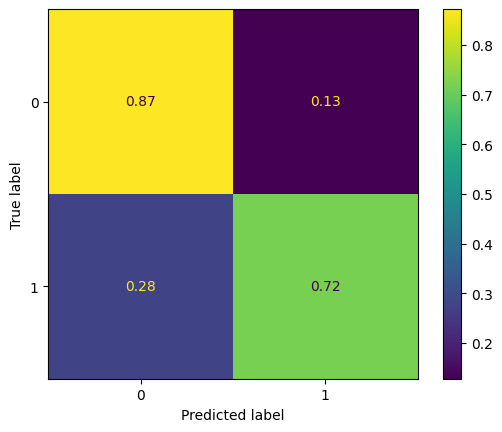

In [51]:
cm = confusion_matrix(y_test, preds, labels=[0,1],normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [52]:
79,79,21,21

(79, 79, 21, 21)

In [53]:
results = pd.DataFrame({'preds':preds,'true':y_test})
# 'prev':X_test['PREV_1_pnls'].values
# results['predicted_pnl'] = results['preds']+results['prev']
# results['actual_pnl'] = results['true']+results['prev']

results

,preds,true
129357,1,1
1367502,0,0
40110,0,0
1049481,0,0
789282,0,0
...,...,...
439929,1,1
664932,1,0
835884,0,0
318000,0,0


In [54]:
results.abs().describe(np.arange(0,1,0.1))

,preds,true
count,113208.000,113208.000
mean,0.318,0.321
std,0.466,0.467
min,0.000,0.000
0%,0.000,0.000
10%,0.000,0.000
20%,0.000,0.000
30%,0.000,0.000
40%,0.000,0.000
50%,0.000,0.000


In [55]:
df['pnls'].describe(np.arange(0,1,0.1))

count   1132073.000
mean          7.459
std         242.997
min       -2689.537
0%        -2689.537
10%        -244.161
20%         -88.052
30%           0.000
40%           0.000
50%           0.000
60%           0.000
70%           4.215
80%         116.047
90%         270.233
max        2712.517
Name: pnls, dtype: float64

In [58]:
m1.save('/home/ec2-user/Capstone/CNN_lob')

INFO:tensorflow:Assets written to: /home/ec2-user/Capstone/CNN_lob/assets


INFO:tensorflow:Assets written to: /home/ec2-user/Capstone/CNN_lob/assets


In [59]:
m2 = get_base_model()
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 3, 64)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 149, 2, 32)        8224      
                                                                 
 flatten (Flatten)           (None, 9536)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2441472   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2450273 (9.35 MB)
Trainable params: 245027

In [60]:
history2 = m2.fit(scaled_X_train,y_train,\
                   epochs=10,\
                   batch_size=512,\
                   validation_data=(scaled_X_val,y_val),\
                   verbose=1,\
#                    callbacks=[earlystopper],\
                   shuffle=True
                  )

Epoch 1/10
1327/1327 [==============================] - 45s 34ms/step - loss: 0.4470 - accuracy: 0.7847 - val_loss: 0.4721 - val_accuracy: 0.7852
Epoch 2/10
1327/1327 [==============================] - 44s 33ms/step - loss: 0.3947 - accuracy: 0.8188 - val_loss: 0.4840 - val_accuracy: 0.7863
Epoch 3/10
1327/1327 [==============================] - 44s 33ms/step - loss: 0.3747 - accuracy: 0.8294 - val_loss: 0.5040 - val_accuracy: 0.7796
Epoch 4/10
1327/1327 [==============================] - 44s 33ms/step - loss: 0.3565 - accuracy: 0.8391 - val_loss: 0.5315 - val_accuracy: 0.7792
Epoch 5/10
1327/1327 [==============================] - 45s 34ms/step - loss: 0.3411 - accuracy: 0.8467 - val_loss: 0.5600 - val_accuracy: 0.7757
Epoch 6/10
1327/1327 [==============================] - 44s 33ms/step - loss: 0.3254 - accuracy: 0.8550 - val_loss: 0.6076 - val_accuracy: 0.7699
Epoch 7/10
1327/1327 [==============================] - 44s 33ms/step - loss: 0.3107 - accuracy: 0.8623 - val_loss: 0.6169 -

3538/3538 [==============================] - 6s 2ms/step


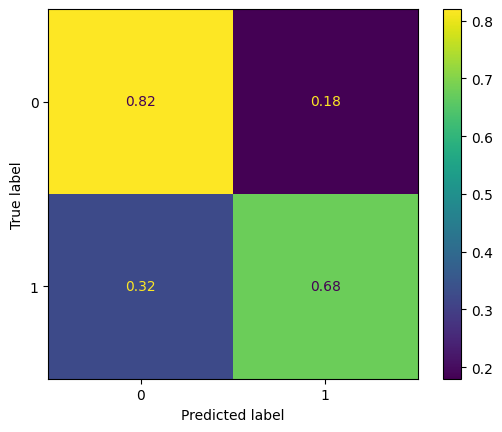

In [61]:
preds2 = m2.predict(scaled_X_test)
preds2 = np.where(preds2.flatten()>0.5,1,0)

cm = confusion_matrix(y_test, preds2, labels=[0,1],normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [62]:
print('weighted f1: ', f1_score(y_test, preds2, average='weighted'))
print('micro f1: ', f1_score(y_test, preds2, average='micro'))
print('macro f1: ', f1_score(y_test, preds2, average='macro'))

weighted f1:  0.7752382131893686
micro f1:  0.7736732386403787
macro f1:  0.7442924493336599


In [68]:
conv1_weights = m1.get_weights()[0]
conv1_weights.shape

(1, 2, 1, 32)

In [75]:
for i in range(conv1_weights.shape[-1]):
    kernel = conv1_weights[:,:,:,i].flatten()
    print('extraced feature is: ', "{:.4f}".format(kernel[0]),'* price + ', "{:.4f}".format(kernel[1]),'* volume')

extraced feature is:  0.0502 * price +  0.0550 * volume
extraced feature is:  -0.2544 * price +  0.0144 * volume
extraced feature is:  0.0105 * price +  0.1266 * volume
extraced feature is:  -0.0886 * price +  0.1037 * volume
extraced feature is:  0.2118 * price +  -0.0958 * volume
extraced feature is:  -0.0233 * price +  -0.0896 * volume
extraced feature is:  0.0574 * price +  0.1116 * volume
extraced feature is:  -0.2518 * price +  0.0270 * volume
extraced feature is:  0.2393 * price +  0.0264 * volume
extraced feature is:  -0.0015 * price +  0.0944 * volume
extraced feature is:  0.0650 * price +  0.1149 * volume
extraced feature is:  0.0296 * price +  0.1417 * volume
extraced feature is:  -0.1724 * price +  0.0468 * volume
extraced feature is:  -0.0423 * price +  0.1400 * volume
extraced feature is:  0.2374 * price +  -0.0699 * volume
extraced feature is:  0.0972 * price +  -0.1204 * volume
extraced feature is:  0.0734 * price +  -0.1107 * volume
extraced feature is:  0.0947 * price

In [80]:
conv2_weights = m1.get_weights()[2]
conv2_weights.shape

(1, 2, 32, 32)

In [95]:
for i in range(conv2_weights.shape[-1]):
    for j in range(conv2_weights.shape[-2]):
        kernel = conv2_weights[:,:,j,i].flatten()
        print('extracted feature is: ', "{:.4f}".format(kernel[0]),'* p1 + ', "{:.4f}".format(kernel[1]),'* p2')

extracted feature is:  0.0013 * p1 +  0.0002 * p2
extracted feature is:  -0.0152 * p1 +  -0.0245 * p2
extracted feature is:  -0.0011 * p1 +  -0.0076 * p2
extracted feature is:  0.0073 * p1 +  0.0004 * p2
extracted feature is:  -0.0174 * p1 +  0.0436 * p2
extracted feature is:  -0.0006 * p1 +  0.0022 * p2
extracted feature is:  0.0030 * p1 +  -0.0038 * p2
extracted feature is:  -0.0082 * p1 +  0.0054 * p2
extracted feature is:  -0.0149 * p1 +  -0.0025 * p2
extracted feature is:  0.0007 * p1 +  -0.0024 * p2
extracted feature is:  -0.0010 * p1 +  -0.0051 * p2
extracted feature is:  -0.0020 * p1 +  0.0052 * p2
extracted feature is:  -0.0043 * p1 +  -0.0074 * p2
extracted feature is:  0.0022 * p1 +  -0.0005 * p2
extracted feature is:  -0.0220 * p1 +  -0.0040 * p2
extracted feature is:  -0.0050 * p1 +  0.0207 * p2
extracted feature is:  -0.0060 * p1 +  -0.0010 * p2
extracted feature is:  -0.0047 * p1 +  0.0080 * p2
extracted feature is:  -0.0049 * p1 +  -0.0066 * p2
extracted feature is:  -0

In [94]:
for i in range(conv2_weights.shape[-1]):
    for j in range(conv2_weights.shape[-2]):
        kernel = conv2_weights[:,:,j,i].flatten()
        if (abs(kernel[0]) > 0.1) or (abs(kernel[1]) > 0.1):
            print('extracted feature is: \n', "{:.4f}".format(kernel[0]),'* p1 + ', "{:.4f}".format(kernel[1]),'* p2')

extracted feature is: 
 0.1069 * p1 +  0.0063 * p2
extracted feature is: 
 -0.0309 * p1 +  -0.1028 * p2
extracted feature is: 
 -0.1086 * p1 +  0.0342 * p2
extracted feature is: 
 0.1129 * p1 +  -0.0736 * p2
extracted feature is: 
 -0.0508 * p1 +  0.1203 * p2
extracted feature is: 
 -0.1108 * p1 +  0.0449 * p2
extracted feature is: 
 0.1114 * p1 +  -0.0629 * p2
extracted feature is: 
 0.1255 * p1 +  -0.0270 * p2
extracted feature is: 
 0.1040 * p1 +  -0.0703 * p2
extracted feature is: 
 0.1336 * p1 +  -0.0651 * p2
extracted feature is: 
 0.1029 * p1 +  -0.0749 * p2
extracted feature is: 
 -0.1051 * p1 +  0.0966 * p2
